# Import

In [1]:
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os

from ClusterPipe import clustpipe

# Parameters

In [2]:
outdir = os.getenv('CTAPHYS_OUT_DIR')+'KESACCO'

### Define the simulation

In [3]:
cpipe = clustpipe.ClusterPipe(silent=False, output_dir=outdir)

             _  __  ___    __    __     ___   ___   __         
            | |/ / | __| /' _/  /  \   / _/  / _/  /__\        
            |   <  | _|  `._`. | /\ | | \__ | \__ | \/ |       
            |_|\_\ |___| |___/ |_||_|  \__/  \__/  \__/        
Keen Event Simulation and Analysis for CTA Cluster Observations
---------------------------------------------------------------


### Define the cluster object

In [4]:
cpipe.cluster.name = 'Perseus'
cpipe.cluster.redshift = 0.0179
cpipe.cluster.M500 = 6.2e14*u.solMass
cpipe.cluster.coord = SkyCoord("3h19m47.2s +41d30m47s", frame='icrs')

# From Churazov et al. (2003)
cpipe.cluster.density_gas_model = {'name':'doublebeta', 'beta1':1.8, 'r_c1':80*u.kpc, 'n_01':3.9e-2*u.cm**-3,
                                   'beta2':0.87, 'r_c2':280*u.kpc, 'n_02':4.05e-3*u.cm**-3}

# Assuming Planck UPP
cpipe.cluster.set_pressure_gas_gNFW_param('P13UPP')

# CR physics
cpipe.cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.3}
cpipe.cluster.set_density_crp_isobaric_scal_param(scal=0.5)
cpipe.cluster.X_cr_E = {'X':1.0, 'R_norm':cpipe.cluster.R500}

# Sampling
cpipe.cluster.Npt_per_decade_integ = 30

# Get information
cpipe.cluster.print_param()

--- theta_truncation
    3.43473598064 deg
    <class 'astropy.units.quantity.Quantity'>
--- abundance
    0.3
    <type 'float'>
--- R_truncation
    4646.03293949 kpc
    <class 'astropy.units.quantity.Quantity'>
--- M500
    6.2e+14 solMass
    <class 'astropy.units.quantity.Quantity'>
--- map_reso
    0.02 deg
    <class 'astropy.units.quantity.Quantity'>
--- theta500
    0.973853085549 deg
    <class 'astropy.units.quantity.Quantity'>
--- Rmin
    1.0 kpc
    <class 'astropy.units.quantity.Quantity'>
--- magfield_model
    {'a': 1.33, 'c500': 1.81, 'c': 0.155, 'b': 2.065, 'name': 'GNFW', 'r_p': <Quantity 855.62300911 kpc>, 'P_0': <Quantity 10. uG>}
    <type 'dict'>
--- density_gas_model
    {'name': 'doublebeta', 'beta2': 0.87, 'beta1': 1.8, 'n_01': <Quantity 0.039 1 / cm3>, 'n_02': <Quantity 0.00405 1 / cm3>, 'r_c1': <Quantity 80. kpc>, 'r_c2': <Quantity 280. kpc>}
    <type 'dict'>
--- Epmin
    1.21793391659 GeV
    <class 'astropy.units.quantity.Quantity'>
--- pp_interaction_

### Define the point source object

In [5]:
# source 1
name='NGC1275'
spatial={'type':'PointSource',
         'param':{'RA': {'value':SkyCoord("3h19m48.16s +41d30m42s").ra.to('deg'),  'free':False},
                  'DEC':{'value':SkyCoord("3h19m48.16s +41d30m42s").dec.to('deg'), 'free':False}}}
spectral={'type':'PowerLaw',
          'param':{'Prefactor':{'value':2.1e-11/u.cm**2/u.TeV/u.s, 'free':True},
                   'Index':{'value':-3.6, 'free':False},
                   'PivotEnergy':{'value':0.2*u.TeV, 'free':False}}}
cpipe.compact_source.add_source(name, spatial, spectral)

# source 2
name='IC310'
spatial={'type':'PointSource',
         'param':{'RA': {'value':SkyCoord("3h16m42.98s +41d19m30s").ra.to('deg'),  'free':False},
                  'DEC':{'value':SkyCoord("3h16m42.98s +41d19m30s").dec.to('deg'), 'free':False}}}
spectral={'type':'PowerLaw',
          'param':{'Prefactor':{'value':4.3e-12/u.cm**2/u.TeV/u.s, 'free':True},
                   'Index':{'value':-1.95, 'free':False},
                   'PivotEnergy':{'value':1.0*u.TeV, 'free':False}}}
cpipe.compact_source.add_source(name, spatial, spectral)

cpipe.compact_source.print_source()

--- NGC1275
    -- Spatial model: PointSource
         DEC: {'free': False, 'value': <Latitude 41.51166667 deg>}
         RA: {'free': False, 'value': <Longitude 49.95066667 deg>}
    -- Spectral model: PowerLaw
         Index: {'free': False, 'value': -3.6}
         PivotEnergy: {'free': False, 'value': <Quantity 0.2 TeV>}
         Prefactor: {'free': True, 'value': <Quantity 2.1e-11 1 / (cm2 s TeV)>}
    -- Temporal model: Constant
         Normalization: {'free': False, 'value': 1.0}
--- IC310
    -- Spatial model: PointSource
         DEC: {'free': False, 'value': <Latitude 41.325 deg>}
         RA: {'free': False, 'value': <Longitude 49.17908333 deg>}
    -- Spectral model: PowerLaw
         Index: {'free': False, 'value': -1.95}
         PivotEnergy: {'free': False, 'value': <Quantity 1. TeV>}
         Prefactor: {'free': True, 'value': <Quantity 4.3e-12 1 / (cm2 s TeV)>}
    -- Temporal model: Constant
         Normalization: {'free': False, 'value': 1.0}


### Define the observations

In [6]:
# One pointing centered on cluster
cpipe.obs_setup.add_obs(obsid='011', name='Perseus_Ptg1', 
                        coord=cpipe.cluster.coord, 
                        rad=4*u.deg, 
                        emin=0.05*u.TeV, emax=100*u.TeV,
                        caldb='prod3b-v2', irf='North_z20_S_5h',
                        tmin='2020-01-01T00:00:00.0', tmax='2020-01-01T01:00:00.0', deadc=0.95)

# One pointing offset +1+1
cpipe.obs_setup.add_obs(obsid='012', name='Perseus_Ptg2', 
                        coord=SkyCoord(cpipe.cluster.coord.ra.value+1, cpipe.cluster.coord.dec.value+1, unit='deg'),
                        rad=6*u.deg,
                        emin=0.06*u.TeV, emax=90*u.TeV,
                        caldb='prod3b-v2', irf='North_z20_S_5h',
                        tmin='2020-01-02T00:00:00.0', tmax='2020-01-02T02:00:00.0', deadc=0.95)

# One pointing offset +0.5-0.5
cpipe.obs_setup.add_obs(obsid='013', name='Perseus_Ptg3', 
                        coord=SkyCoord(cpipe.cluster.coord.ra.value+0.5, cpipe.cluster.coord.dec.value-0.5, unit='deg'),
                        rad=5*u.deg, 
                        emin=0.05*u.TeV, emax=90*u.TeV,
                        caldb='prod3b-v2', irf='North_z20_S_5h',
                        tmin='2020-01-03T00:00:00.0', tmax='2020-01-03T01:30:00.0', deadc=0.95)


# One pointing offset +1+1
cpipe.obs_setup.add_obs(obsid='014', name='Perseus_Ptg4', 
                        coord=SkyCoord(cpipe.cluster.coord.ra.value-1, cpipe.cluster.coord.dec.value-1, unit='deg'),
                        rad=7*u.deg,
                        emin=0.06*u.TeV, emax=120*u.TeV,
                        caldb='prod3b-v2', irf='North_z20_S_5h',
                        tmin='2020-01-04T00:00:00.0', tmax='2020-01-04T02:00:00.0', deadc=0.95)

# One pointing offset +0.5-0.5
cpipe.obs_setup.add_obs(obsid='015', name='Perseus_Ptg5', 
                        coord=SkyCoord(cpipe.cluster.coord.ra.value-0.5, cpipe.cluster.coord.dec.value+0.5, unit='deg'),
                        rad=5*u.deg, 
                        emin=0.07*u.TeV, emax=140*u.TeV,
                        caldb='prod3b-v2', irf='North_z20_S_5h',
                        tmin='2020-01-05T00:00:00.0', tmax='2020-01-05T02:30:00.0', deadc=0.95)

# Print info
cpipe.obs_setup.print_obs()

=== Perseus_Ptg1, ObsID 011
        RA-Dec:    49.9466666667, 41.5130555556 deg
        GLON-GLAT: 150.572480744, -13.2617332972 deg
        ROI rad: 4.0 deg
        tmin: 2020-01-01T00:00:00.0
        tmax: 2020-01-01T01:00:00.0
        emin: 0.05 TeV
        emax: 100.0 TeV
        deadc: 0.95
        caldb: prod3b-v2
        irf: North_z20_S_5h
        bkg: name Background, obsid None, spatial type CTAIrfBackground, spectral type PowerLaw
=== Perseus_Ptg2, ObsID 012
        RA-Dec:    50.9466666667, 42.5130555556 deg
        GLON-GLAT: 150.635045991, -12.0174437848 deg
        ROI rad: 6.0 deg
        tmin: 2020-01-02T00:00:00.0
        tmax: 2020-01-02T02:00:00.0
        emin: 0.06 TeV
        emax: 90.0 TeV
        deadc: 0.95
        caldb: prod3b-v2
        irf: North_z20_S_5h
        bkg: name Background, obsid None, spatial type CTAIrfBackground, spectral type PowerLaw
=== Perseus_Ptg3, ObsID 013
        RA-Dec:    50.4466666667, 41.0130555556 deg
        GLON-GLAT: 151.179005

# Run the simulation

In [7]:
#cpipe.run_sim_obs()
#cpipe.run_sim_quicklook(ShowEvent=True, ShowObsDef=True, ShowSkyModel=True,
#                        bkgsubtract='IRF', smoothing_FWHM=0.2*u.deg)

# Run the analysis

In [8]:
#----- Analysis parameters
cpipe.method_binned = True
cpipe.method_stack  = True
cpipe.spec_enumbins = 20
cpipe.map_reso      = 0.05*u.deg

obsID = ['011', '012', '013', '014', '015']

In [9]:
#cpipe.run_ana_dataprep(obsID=obsID)

In [10]:
#cpipe.run_ana_likelihood()

In [11]:
#cpipe.run_ana_imaging(bkgsubtract='IRF', do_TS=False, do_Res=True, do_Skymap=True, do_SourceDet=False)
cpipe.run_ana_spectral()

--- Computing spectrum: Perseus
=== GApplication ===
 Name ......................: ctbutterfly
 Version ...................: 1.6.3
 inobs .....................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO/Ana_Countscube.fits
 inmodel ...................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO/Ana_Model_Output.xml
 srcname ...................: Perseus
 expcube ...................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO/Ana_Expcube.fits
 psfcube ...................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO/Ana_Psfcube.fits
 edispcube .................: NONE
 bkgcube ...................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO/Ana_Bkgcube.fits
 caldb .....................: prod2
 irf .......................: South_0.5h
 edisp .....................: no
 outfile ...................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO/Ana_Spectrum_Buterfly_Perseus.txt
 method ....................: GAUSSIAN
 fit .......................: no
 confidence ................: 0.68
 st

In [12]:
cpipe.run_ana_plot(obsID=obsID)

----- ObsID to be looked at: ['011', '012', '013', '014', '015']


/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


=== GApplication ===
 Name ......................: ctskymap
 Version ...................: 1.6.3
 inobs .....................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO/Ana_SelectedEvents011.fits
 caldb .....................: prod3b-v2
 irf .......................: North_z20_S_5h
 inmap .....................: NONE
 outmap ....................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO/Ana_Skymap011.fits
 emin ......................: 0.05
 emax ......................: 100
 usepnt ....................: no
 nxpix .....................: 81
 nypix .....................: 81
 binsz .....................: 0.05
 coordsys ..................: CEL
 proj ......................: TAN
 xref ......................: 49.9466666666667
 yref ......................: 41.5130555555556
 bkgsubtract ...............: NONE
 roiradius .................: 0.1
 inradius ..................: 1
 outradius .................: 2
 iterations ................: 3
 threshold .................: 3
 inexclusion .............

/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/numpy/ma/core.py:6666: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: divide by zero encountered in true_divide
  *arrays, **kwargs)
/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in true_divide
  *arrays, **kwargs)
/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in greater
  *arrays, **kwargs)


# Compare profile to input

In [13]:
#----- Get the data
pdata = fits.open(cpipe.output_dir+'/Ana_ResmapCluster_profile.fits')[1]
prof = pdata.data

In [14]:
#----- Get the expectation for input model
import gammalib
from ClusterPipe.Tools import build_ctools_model
from ClusterPipe.Tools import cubemaking

model_in = gammalib.GModels()
build_ctools_model.cluster(model_in,
                           cpipe.output_dir+'/Ana_Model_Input_Map.fits',
                           cpipe.output_dir+'/Ana_Model_Input_Spectrum.txt',
                           ClusterName=cpipe.cluster.name)
model_in.save(cpipe.output_dir+'/Postana_Cluster_model.xml')

cpipe._match_cluster_to_pointing()
cpipe._match_anamap_to_pointing()
modcube_Cl = cubemaking.model_cube(cpipe.output_dir,
                                   cpipe.map_reso, cpipe.map_coord, cpipe.map_fov,
                                   cpipe.spec_emin, cpipe.spec_emax, cpipe.spec_enumbins, cpipe.spec_ebinalg,
                                   edisp=cpipe.spec_edisp,
                                   stack=True, silent=cpipe.silent,
                                   inmodel_usr=cpipe.output_dir+'/Postana_Cluster_model.xml',
                                   outmap_usr=cpipe.output_dir+'/Postana_Cluster_model.fits')

=== GApplication ===
 Name ......................: ctmodel
 Version ...................: 1.6.3
 inobs .....................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO/Ana_Countscube.fits
 incube ....................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO/Ana_Countscube.fits
 inmodel ...................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO/Postana_Cluster_model.xml
 expcube ...................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO/Ana_Expcube.fits
 psfcube ...................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO/Ana_Psfcube.fits
 edispcube .................: NONE
 bkgcube ...................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO/Ana_Bkgcube.fits
 caldb .....................: NONE
 irf .......................: NONE
 edisp .....................: no
 outcube ...................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO/Postana_Cluster_model.fits
 ra ........................: NONE
 dec .......................: NONE
 rad .......................

In [15]:
mcube = fits.open(cpipe.output_dir+'/Postana_Cluster_model.fits')
header = mcube[0].header
model_cnt_map = np.sum(mcube[0].data,axis=0)
header.remove('NAXIS3')
header['NAXIS'] = 2

In [16]:
from ClusterModel.ClusterTools.map_tools import radial_profile
r_mod, p_mod, err_mod = radial_profile(model_cnt_map,
                                   [cpipe.cluster.coord.icrs.ra.to_value('deg'),
                                    cpipe.cluster.coord.icrs.dec.to_value('deg')],
                                   stddev=np.sqrt(model_cnt_map), header=header,
                                   binsize=0.05, stat='POISSON',
                                   counts2brightness=True)

/Users/adam/Project/CTA/Phys/Software/ClusterModel/ClusterTools/map_tools.py:470: RuntimeWarning: invalid value encountered in double_scalars
  sig     = np.sign(cts_dat-cts_exp)*np.sqrt(2*(cts_dat*np.log(cts_dat/cts_exp) + cts_exp - cts_dat))
/Users/adam/Project/CTA/Phys/Software/ClusterModel/ClusterTools/map_tools.py:476: RuntimeWarning: invalid value encountered in double_scalars
  val     /= (Npix_bin*reso_x*reso_y)


Text(0,0.5,'$\\chi$')

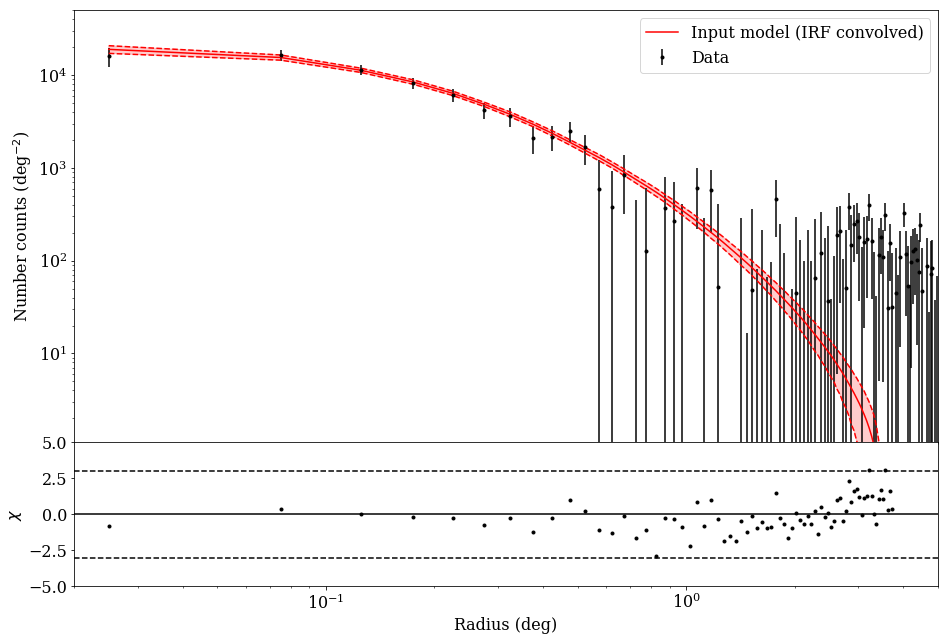

In [17]:
fig = plt.figure(0, figsize=(15,10))

# Frame 1
frame1 = fig.add_axes((.1,.3,.8,.6))

plt.errorbar(prof['radius'], prof['profile'], prof['error'], color='k', marker='.', linestyle='', label='Data')
plt.fill_between(r_mod, p_mod+err_mod, p_mod-err_mod, color='red', alpha=0.2)
plt.plot(r_mod, p_mod, color='red', label='Input model (IRF convolved)')
plt.plot(r_mod, p_mod+err_mod, color='red', linestyle='--')
plt.plot(r_mod, p_mod-err_mod, color='red', linestyle='--')

plt.ylabel('Number counts (deg$^{-2}$)')
plt.xlim(2e-2, 5)
plt.ylim(1.1, 5e4)
plt.xticks([])
plt.xscale('log')
plt.yscale('log')
plt.legend()

# Frame2
frame2 = fig.add_axes((.1,.1,.8,.2))
plt.plot(prof['radius'], (prof['profile']-p_mod)/prof['error'], color='k', marker='.', linestyle='')
plt.hlines(0,  2e-2, 5, linestyle='-')
plt.hlines(-3, 2e-2, 5, linestyle='--')
plt.hlines(+3, 2e-2, 5, linestyle='--')
plt.xscale('log')
plt.xlim(2e-2, 5)
plt.ylim(-5, 5)
plt.xscale('log')
plt.xlabel('Radius (deg)')
plt.ylabel('$\\chi$')